In [31]:
import pandas as pd
import numpy as np
import os

def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()


path = open(r"C:\Users\wivillarino\Documents\train.csv")
data = pd.read_csv(path, index_col='id', parse_dates=['date'])
data.head()
data2 = data.loc[((data['store_nbr'] == 1) & (data['family'] == 'MEATS')), ['date', 'sales', 'onpromotion']]

#empty list
dec25 = list()
#This data doesn’t contain a record for December 25, below is just copying the sales from December 18 to December 25 to keep the weekly pattern.
for year in range(2013,2017):
    dec18 = data2.loc[(data2['date'] == f'{year}-12-18')]
    dec25 += [{'date': pd.Timestamp(f'{year}-12-25'), 'sales': dec18['sales'].values[0], 'onpromotion': dec18['onpromotion'].values[0]}]
data2 = pd.concat([data2, pd.DataFrame(dec25)], ignore_index=True).sort_values('date')

#To validate our models, we will use a simple time split, taking the first 3 months of 2017 as validation data and everything before that as training data.
train = data2.loc[data2['date'] < '2017-01-01']
valid = data2.loc[(data2['date'] >= '2017-01-01') & (data2['date'] < '2017-04-01')]


In [32]:
import orbit
from orbit.models import ETS

ets = ETS(date_col='date', 
          response_col='sales', 
          seasonality=7,
          prediction_percentiles=[5, 95],
          seed=1)

Fitting the model to the training data.

In [33]:
train_ets = train[['date', 'sales']].copy()

ets.fit(df=train_ets)

2024-02-08 15:55:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 4, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [34]:
forecast_df = pd.DataFrame({"date": pd.date_range(start='2017-01-01', end='2017-03-31', freq='D')})
p = ets.predict(df=forecast_df)
p = p.merge(valid, on='date', how='left')

print(wmape(p['sales'], p['prediction']))

0.20647357000913286


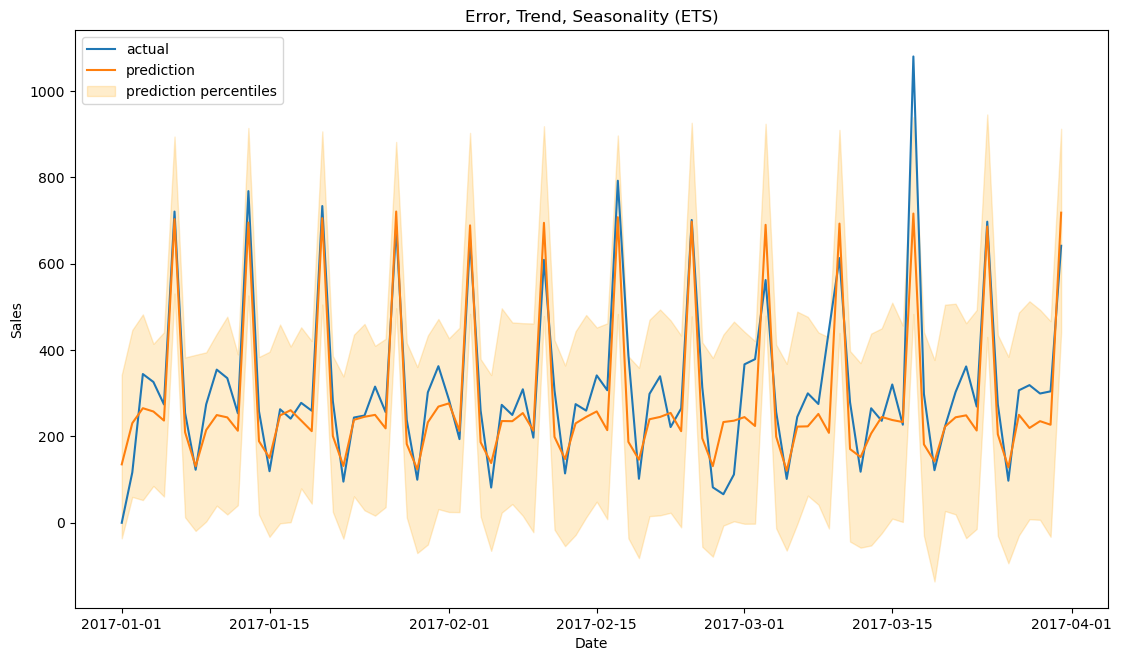

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p['date'], p['sales'], label='actual')
ax.plot(p['date'], p['prediction'], label='prediction')
ax.fill_between(p['date'], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Error, Trend, Seasonality (ETS)')
ax.set_ylabel('Sales')
ax.set_xlabel('Date')
ax.legend()
plt.show()